In [21]:
import matplotlib.pyplot as plt
%matplotlib inline 

import sys
import datacube 
import numpy as np
import xarray as xr
import s2cloudmask #developed by Dale 

sys.path.append("../Scripts")

In [7]:
from deafrica_datahandling import load_ard
from deafrica_plotting import rgb
from deafrica_plotting import display_map 
from odc.algo import xr_geomedian

In [9]:
dc = datacube.Datacube(app="Geomedian_composite")

In [10]:
#loading Sentinel-2 cloud masked data 
x = (-1.15,-1.19)
y = (5.14, 5.18)
display_map(x,y)

In [11]:
sentinel_2_ds = load_ard(
    dc = dc,
    products = ["s2_l2a"],
    x=x,y=y,
    time = ("2018-02-01","2018-03-15"),
    output_crs = "EPSG:6933",
    measurements = ["red","green","blue"],
    resolution = (-10,10),
    group_by = 'solar_day',
    min_gooddata=0.7)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step
Filtering to 4 out of 9 time steps with at least 70.0% good quality pixels
Applying pixel quality/cloud mask
Loading 4 time steps


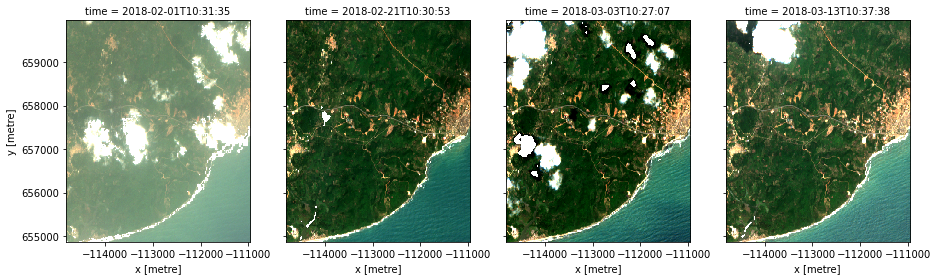

In [17]:
rgb(sentinel_2_ds,bands=["red","green","blue"],col='time',size=4)

In [18]:
sentinel_2_ds

<xarray.Dataset>
Dimensions:      (time: 4, x: 386, y: 509)
Coordinates:
    spatial_ref  int32 6933
  * y            (y) float64 6.6e+05 6.599e+05 6.599e+05 ... 6.549e+05 6.549e+05
  * time         (time) datetime64[ns] 2018-02-01T10:31:35 ... 2018-03-13T10:...
  * x            (x) float64 -1.148e+05 -1.148e+05 ... -1.11e+05 -1.11e+05
Data variables:
    red          (time, y, x) float32 1020.0 1036.0 1016.0 ... 757.0 762.0 733.0
    green        (time, y, x) float32 1180.0 1156.0 1168.0 ... 1050.0 1076.0
    blue         (time, y, x) float32 973.0 975.0 984.0 ... 1062.0 1056.0 1076.0
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

In [19]:
geomedian_composite = xr_geomedian(sentinel_2_ds)

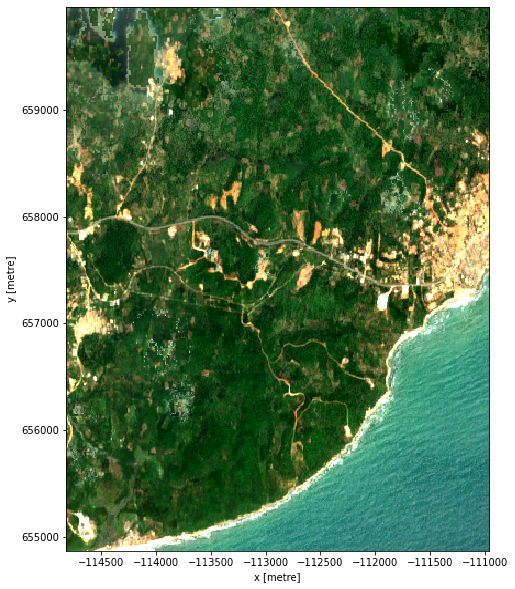

In [20]:
rgb(geomedian_composite,bands=["red","green","blue"],size=10)

## Testing ESA SCL and Dale's Cloud Mask in part of Lagos 

In [22]:
lat, lon = 6.448191, 3.207363 #lagos
buffer = 0.075
# Create a reusable query
query = {
    'x': (lon - buffer, lon + buffer),
    'y':  (lat + buffer, lat - buffer),
    'time': ('2019-01-01', '2019-02-06'),
    'resolution': (-20, 20),
    'measurements': ['blue', 'green', 'red', 'red_edge_1', 'red_edge_2',
                     'red_edge_3', 'nir_1','nir_2', 'swir_1', 'swir_2'],
}

In [23]:
dc = datacube.Datacube(app='S2_cloud_mask')

In [24]:
# Load available data
ds = dc.load(product='s2_l2a',
              group_by='solar_day',
              output_crs='epsg:6933',
              **query)
# Print output data
print(ds)

<xarray.Dataset>
Dimensions:      (time: 8, x: 725, y: 952)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-01T10:19:00 ... 2019-02-05T10:...
  * y            (y) float64 8.304e+05 8.304e+05 ... 8.114e+05 8.114e+05
  * x            (x) float64 3.022e+05 3.022e+05 ... 3.167e+05 3.167e+05
    spatial_ref  int32 6933
Data variables:
    blue         (time, y, x) uint16 307 298 280 387 303 ... 993 1021 1002 1002
    green        (time, y, x) uint16 550 677 591 667 634 ... 915 919 902 916 908
    red          (time, y, x) uint16 521 538 520 546 525 ... 790 799 788 769 769
    red_edge_1   (time, y, x) uint16 1021 1006 1053 1051 ... 826 830 829 827
    red_edge_2   (time, y, x) uint16 2275 2393 2444 2536 ... 788 785 780 773
    red_edge_3   (time, y, x) uint16 2803 2951 2892 3032 ... 762 755 762 775
    nir_1        (time, y, x) uint16 2790 3162 2814 3200 ... 730 727 724 718
    nir_2        (time, y, x) uint16 3090 3220 3203 3305 ... 705 700 711 723
    swir_1       (time, y, x)

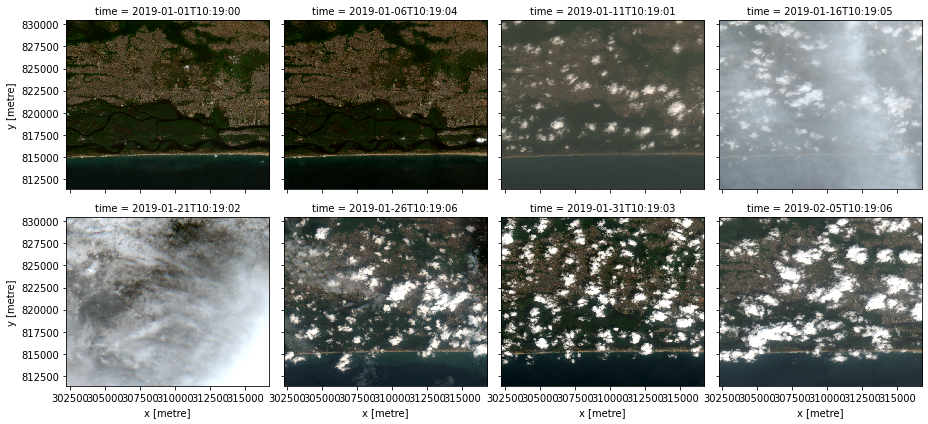

In [25]:
rgb_bands = ['red', 'green', 'blue']

(ds[rgb_bands] ** 0.5).to_array().plot.imshow(
    robust=True, col='time', col_wrap=4)

In [29]:
# Rearrange band order to (y, x, bands, time)
data = ds.transpose("y", "x", "time").to_array().values
data = np.moveaxis(data, 0, -2)

#normalise data
data = data.astype(np.float32)
data[(data.data == 0)] = np.nan
data = data.clip(0, 10000)
data /= 10000.

In [30]:
%%time
# Run classifier
# mask_array = s2cloudmask.cloud_mask(data, model='spectral')
mask_array = s2cloudmask.cloud_probs(data, model='spectral') < 0.20

# Convert output to xarray
mask_da = xr.DataArray(mask_array, dims=['y', 'x', 'time'], 
                       coords={'x': ds.x, 'y': ds.y, 'time': ds.time})

CPU times: user 4min 52s, sys: 1.5 s, total: 4min 54s
Wall time: 26.6 s


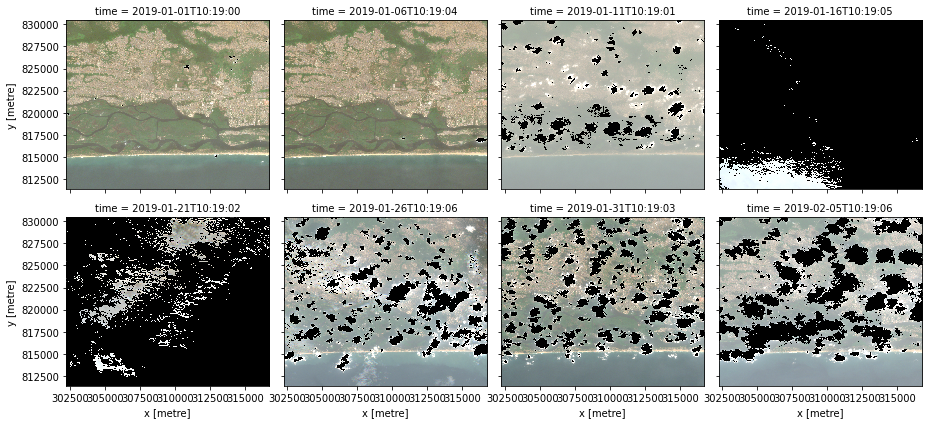

In [33]:
(ds[rgb_bands] ** 0.5).where(mask_da, 0).to_array().plot.imshow(
    robust=True, col='time', col_wrap=4)

## Compare with ESA SCL band 

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying pixel quality/cloud mask
Loading 8 time steps


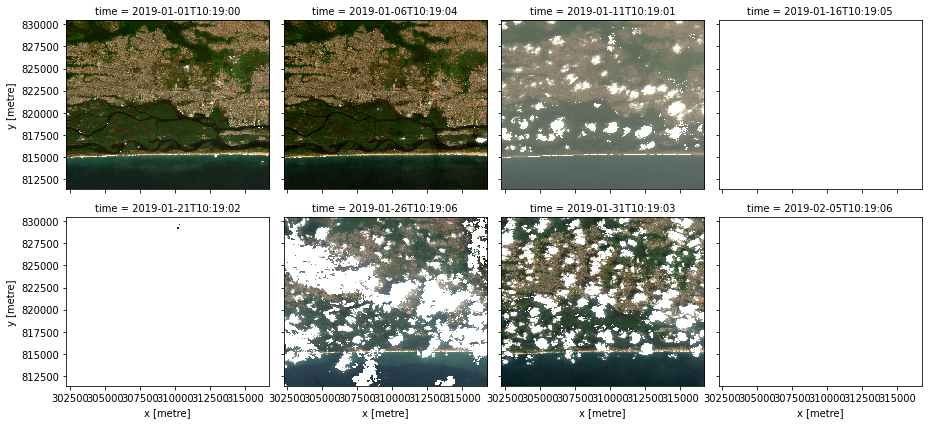

In [34]:
# Load available data
ds_scl = load_ard(dc=dc, 
              products=['s2_l2a'],
              group_by='solar_day',
              output_crs='epsg:6933', 
              **query)

(ds_scl[rgb_bands] ** 0.5).to_array().plot.imshow(
    robust=True, col='time', col_wrap=4)